# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.std()

0.99589320646770185

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20','time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)

        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            Train.best_acc = 0
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.2)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:1, net.lr:lr})

                        train_batch()
                        count = 10
                        
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})

                    test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test, 
                                                                                     net.y_: preprocess.y_test, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    
                    test_accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test_, 
                                                                                     net.y_: preprocess.y_test_, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)

                    if epoch % 1 == 0:
                        print("Step {} | Training Loss: {:.6f} | Test Loss: {:.6f} | Test Accuracy: {:.6f}, {:6f}"
                              .format(epoch, train_loss, test_loss, test_accuracy, test_accuracy_))

                    if test_accuracy > Train.best_acc_global:
                        Train.best_acc_global = test_accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if test_accuracy > Train.best_acc:
                        Train.best_acc = test_accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, test_accuracy, test_accuracy_, time.perf_counter() - start_time))})
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
            print("Best Accuracy on Test data: {}".format(Train.best_acc))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [30]
    lrs = [1e-2, 1e-3]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.000258 | Test Loss: 0.000442 | Test Accuracy: 0.804294, 0.665316
Step 2 | Training Loss: 0.000235 | Test Loss: 0.000494 | Test Accuracy: 0.771824, 0.611139
Step 3 | Training Loss: 0.000182 | Test Loss: 0.000301 | Test Accuracy: 0.794225, 0.642700
Step 4 | Training Loss: 0.000072 | Test Loss: 0.000133 | Test Accuracy: 0.810548, 0.682447
Step 5 | Training Loss: 0.000061 | Test Loss: 0.000375 | Test Accuracy: 0.840312, 0.734684
Step 6 | Training Loss: 0.000082 | Test Loss: 9.455018 | Test Accuracy: 0.840933, 0.738481
Step 7 | Training Loss: 0.000089 | Test Loss: 0.000386 | Test Accuracy: 0.831840, 0.720253
Step 8 | Training Loss: 0.000006 | Test Loss: 0.000212 | Test Accuracy: 0.846301, 0.742700
Step 9 | Training Loss: 0.000039 | Test Loss: 0.000175 | Test Accuracy: 0.859697, 0.759072
Step 10 | Training Loss: 0.000026 | Test Loss: 0.000199 | Test Accuracy: 0.850914, 0.749958
Step 11 | Training 

Step 4 | High Training Loss: 24026962554669004245434368.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_30_features count_2/model-3
Step 4 | High Training Loss: 24026962554669004245434368.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_30_features count_2/model-3
Step 4 | Training Loss: 0.000278 | Test Loss: 0.001075 | Test Accuracy: 0.824787, 0.706160
Step 5 | Training Loss: 0.000099 | Test Loss: 0.000503 | Test Accuracy: 0.832594, 0.733586
Step 6 | Training Loss: 0.000021 | Test Loss: 0.000274 | Test Accuracy: 0.846345, 0.738903
Step 7 | Training Loss: 0.000054 | Test Loss: 0.000145 | Test Accuracy: 0.856148, 0.760422
Step 8 | Training Loss: 0.000010 | Test Loss: 0.000217 | Test Accuracy: 0.863556, 0.763376
Step 9 | Training Loss: 0.000021 | Test Loss: 0.000230 | Test Accuracy: 0.869056, 0.773333
Step 10 | Training Loss: 0.00004

Step 15 | Training Loss: 0.000077 | Test Loss: 0.000337 | Test Accuracy: 0.733943, 0.584641
Step 16 | Training Loss: 0.000045 | Test Loss: 0.000296 | Test Accuracy: 0.756077, 0.625063
Step 17 | Training Loss: 0.000069 | Test Loss: 0.000286 | Test Accuracy: 0.788857, 0.672236
Step 18 | Training Loss: 0.000063 | Test Loss: 0.000256 | Test Accuracy: 0.781183, 0.676709
Step 19 | Training Loss: 0.000019 | Test Loss: 0.000199 | Test Accuracy: 0.761577, 0.625823
Step 20 | Training Loss: 0.000075 | Test Loss: 0.000126 | Test Accuracy: 0.780075, 0.641772
Step 21 | Training Loss: 0.000011 | Test Loss: 0.000456 | Test Accuracy: 0.792672, 0.676456
Step 22 | High Training Loss: 11344415.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_30_features count_2/model-9
Step 22 | Training Loss: 0.000124 | Test Loss: 0.000238 | Test Accuracy: 0.811480, 0.657215
Step 23 | Training Loss: 0.000073 | Test Loss: 0.000188 | Test Accurac

Step 5 | High Training Loss: 13729.141602 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_30_features count_2/model-4
Step 5 | High Training Loss: 13742.426758 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_30_features count_2/model-4
Step 5 | High Training Loss: 25792240685154304.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_30_features count_2/model-4
Step 5 | High Training Loss: 110011873411639279616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_30_features count_2/model-4
Step 5 | High Training Loss: 110011873411639279616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_30_features count_2/model-4
Step 5

Step 21 | Training Loss: 0.000040 | Test Loss: 0.000191 | Test Accuracy: 0.880589, 0.787257
Step 22 | Training Loss: 0.000061 | Test Loss: 0.000185 | Test Accuracy: 0.880412, 0.786582
Step 23 | Training Loss: 0.000028 | Test Loss: 0.000185 | Test Accuracy: 0.880456, 0.787426
Step 24 | Training Loss: 0.000019 | Test Loss: 0.000198 | Test Accuracy: 0.881654, 0.788270
Step 25 | Training Loss: 0.000008 | Test Loss: 0.000190 | Test Accuracy: 0.881698, 0.788692
Step 26 | Training Loss: 0.000016 | Test Loss: 0.000195 | Test Accuracy: 0.882541, 0.790717
Step 27 | Training Loss: 0.000008 | Test Loss: 0.000183 | Test Accuracy: 0.882630, 0.791139
Step 28 | Training Loss: 0.000003 | Test Loss: 0.000176 | Test Accuracy: 0.883605, 0.792236
Step 29 | Training Loss: 0.000005 | Test Loss: 0.000168 | Test Accuracy: 0.883162, 0.792068
Step 30 | Training Loss: 0.000005 | Test Loss: 0.000181 | Test Accuracy: 0.882275, 0.789620
Best Accuracy on Test data: 0.883605420589447
Current Layer Attributes - epochs:

Step 14 | Training Loss: 0.000013 | Test Loss: 0.000318 | Test Accuracy: 0.712828, 0.534937
Step 15 | Training Loss: 0.000013 | Test Loss: 0.000329 | Test Accuracy: 0.710921, 0.507089
Step 16 | Training Loss: 0.000068 | Test Loss: 0.000339 | Test Accuracy: 0.701739, 0.488186
Step 17 | Training Loss: 0.000035 | Test Loss: 0.000295 | Test Accuracy: 0.716865, 0.522363
Step 18 | Training Loss: 0.000046 | Test Loss: 0.000281 | Test Accuracy: 0.689585, 0.485485
Step 19 | Training Loss: 0.000005 | Test Loss: 0.000312 | Test Accuracy: 0.702049, 0.495865
Step 20 | Training Loss: 0.000003 | Test Loss: 0.000312 | Test Accuracy: 0.702537, 0.497975
Step 21 | Training Loss: 0.000011 | Test Loss: 0.000267 | Test Accuracy: 0.722942, 0.526245
Step 22 | Training Loss: 0.000023 | Test Loss: 0.000329 | Test Accuracy: 0.714824, 0.502110
Step 23 | Training Loss: 0.000024 | Test Loss: 0.000292 | Test Accuracy: 0.729817, 0.547004
Step 24 | Training Loss: 0.000016 | Test Loss: 0.000259 | Test Accuracy: 0.65662

Step 10 | Training Loss: 0.000040 | Test Loss: 0.000161 | Test Accuracy: 0.805625, 0.637722
Step 11 | Training Loss: 0.000016 | Test Loss: 0.000158 | Test Accuracy: 0.806423, 0.638397
Step 12 | Training Loss: 0.000006 | Test Loss: 0.000161 | Test Accuracy: 0.806556, 0.638481
Step 13 | Training Loss: 0.000018 | Test Loss: 0.000159 | Test Accuracy: 0.806512, 0.638397
Step 14 | Training Loss: 0.000005 | Test Loss: 0.000155 | Test Accuracy: 0.806689, 0.638819
Step 15 | Training Loss: 0.000002 | Test Loss: 0.000157 | Test Accuracy: 0.806467, 0.638734
Step 16 | Training Loss: 0.000013 | Test Loss: 0.000147 | Test Accuracy: 0.806423, 0.638481
Step 17 | Training Loss: 0.000009 | Test Loss: 0.000156 | Test Accuracy: 0.806645, 0.638481
Step 18 | Training Loss: 0.000007 | Test Loss: 0.000159 | Test Accuracy: 0.806556, 0.639241
Step 19 | Training Loss: 0.000009 | Test Loss: 0.000159 | Test Accuracy: 0.807044, 0.638565
Step 20 | Training Loss: 0.000006 | Test Loss: 0.000155 | Test Accuracy: 0.80668

Step 5 | Training Loss: 0.000054 | Test Loss: 0.000279 | Test Accuracy: 0.681867, 0.591646
Step 6 | Training Loss: 0.000064 | Test Loss: 0.000376 | Test Accuracy: 0.649086, 0.503966
Step 7 | Training Loss: 0.000222 | Test Loss: 0.000494 | Test Accuracy: 0.725559, 0.529873
Step 8 | Training Loss: 0.000148 | Test Loss: 0.000111 | Test Accuracy: 0.766102, 0.641772
Step 9 | Training Loss: 0.000057 | Test Loss: 0.000127 | Test Accuracy: 0.591244, 0.392405
Step 10 | Training Loss: 0.000208 | Test Loss: 0.000220 | Test Accuracy: 0.738911, 0.611730
Step 11 | Training Loss: 0.000001 | Test Loss: 0.000245 | Test Accuracy: 0.752307, 0.621350
Step 12 | Training Loss: 0.000037 | Test Loss: 0.000190 | Test Accuracy: 0.762775, 0.646920
Step 13 | Training Loss: 0.000048 | Test Loss: 0.000212 | Test Accuracy: 0.780562, 0.666413
Step 14 | Training Loss: 0.000018 | Test Loss: 0.000288 | Test Accuracy: 0.787660, 0.675359
Step 15 | Training Loss: 0.000063 | Test Loss: 0.000158 | Test Accuracy: 0.791607, 0.

Step 29 | Training Loss: 0.000153 | Test Loss: 0.000381 | Test Accuracy: 0.517433, 0.319072
Step 30 | Training Loss: 0.000049 | Test Loss: 0.000356 | Test Accuracy: 0.519429, 0.309705
Step 1 | Training Loss: 0.000086 | Test Loss: 0.000279 | Test Accuracy: 0.519163, 0.309705
Step 2 | Training Loss: 0.000005 | Test Loss: 0.000241 | Test Accuracy: 0.517654, 0.307679
Step 3 | Training Loss: 0.000042 | Test Loss: 0.000234 | Test Accuracy: 0.519251, 0.308608
Step 4 | Training Loss: 0.000047 | Test Loss: 0.000228 | Test Accuracy: 0.522312, 0.307511
Step 5 | Training Loss: 0.000022 | Test Loss: 0.000227 | Test Accuracy: 0.520227, 0.304051
Step 6 | Training Loss: 0.000046 | Test Loss: 0.000224 | Test Accuracy: 0.525417, 0.299578
Step 7 | Training Loss: 0.000018 | Test Loss: 0.000241 | Test Accuracy: 0.519917, 0.300591
Step 8 | Training Loss: 0.000017 | Test Loss: 0.000225 | Test Accuracy: 0.518852, 0.292996
Step 9 | Training Loss: 0.000026 | Test Loss: 0.000228 | Test Accuracy: 0.520981, 0.2928

Step 24 | Training Loss: 0.000012 | Test Loss: 0.000152 | Test Accuracy: 0.760735, 0.583797
Step 25 | Training Loss: 0.000018 | Test Loss: 0.000149 | Test Accuracy: 0.768808, 0.593333
Step 26 | Training Loss: 0.000001 | Test Loss: 0.000178 | Test Accuracy: 0.775062, 0.605232
Step 27 | Training Loss: 0.000015 | Test Loss: 0.000162 | Test Accuracy: 0.782470, 0.611899
Step 28 | Training Loss: 0.000011 | Test Loss: 0.000173 | Test Accuracy: 0.781893, 0.611646
Step 29 | Training Loss: 0.000015 | Test Loss: 0.000147 | Test Accuracy: 0.785131, 0.614515
Step 30 | Training Loss: 0.000006 | Test Loss: 0.000150 | Test Accuracy: 0.782425, 0.608861
Best Accuracy on Test data: 0.8661284446716309
Current Layer Attributes - epochs:30 hidden layers:6 features count:32
Step 1 | Training Loss: 0.000115 | Test Loss: 0.000277 | Test Accuracy: 0.805891, 0.647004
Step 2 | Training Loss: 0.000080 | Test Loss: 0.000391 | Test Accuracy: 0.793914, 0.629451
Step 3 | Training Loss: 0.000095 | Test Loss: 0.000168 |

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
7,60,32,4,0.891010,0.901082,0.831983,171.832848
0,60,4,2,0.938321,0.887376,0.795274,206.089209
1,60,8,2,0.916452,0.885868,0.795105,188.690874
3,60,32,2,0.921492,0.883605,0.792236,233.175519
6,60,16,4,0.916174,0.878460,0.787173,49.377280
10,60,16,6,0.899742,0.866128,0.760422,136.489631
9,60,8,6,0.854297,0.864532,0.778312,213.884803
11,60,32,6,0.850010,0.861116,0.750633,37.115757
8,60,4,6,0.809962,0.838272,0.733165,197.642441
2,60,16,2,0.920063,0.837873,0.711308,95.061680


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8578  0.1422]
 [ 0.0662  0.9338]]


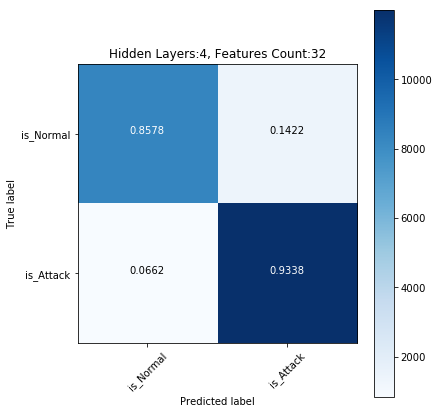

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.4633  0.5367]
 [ 0.0862  0.9138]]


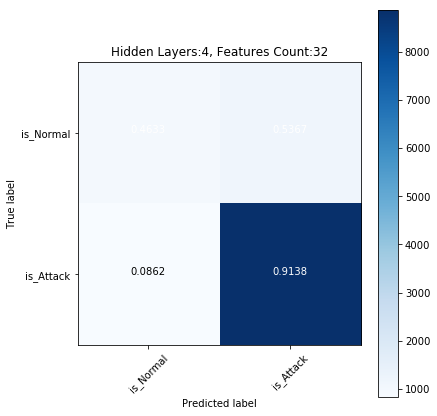

In [17]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)